In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown
tf.config.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
#Download Data
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=c8b63c95-4a73-4a0f-91df-e4bc7189c9de
To: /content/data.zip
100%|██████████| 423M/423M [00:06<00:00, 60.7MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [60]:
# Define the load_data function
def load_data(path: str):
    # Convert the path to a string (if it's a Tensor) and remove potential leading/trailing whitespace
    path = path.numpy().decode('utf-8').strip()

    # Get the file name from the path (handling different path separators)
    file_name = os.path.basename(path).split('.')[0]

    # Define the video and alignment paths
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Load the video and alignment data
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [48]:

# Define the load_video function
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [49]:

# Define the load_alignments function
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, line[2]]
    return tokens

In [50]:
#num to char and inverse
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

['bin', 'blue', 'at', 'l', 'six', 'now']

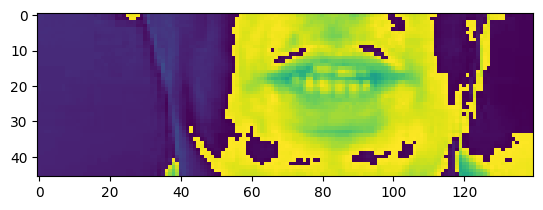

In [51]:
#test working of frames & alignments
test_path = '.\\data\\s1\\bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
frames, alignments = load_data(tf.convert_to_tensor(test_path))
plt.imshow(frames[40])
alignments


In [56]:
result= ' '.join(alignments)
result

'bin blue at l six now'

In [57]:
# Define the mappable_function
def mappable_function(path: str) -> List[str]:
    return load_data(path)

# Create a TensorFlow dataset
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

# Shuffle the dataset
data = data.shuffle(500, reshuffle_each_iteration=False)

# Map the mappable_function to the dataset
data = data.map(lambda x: tf.py_function(mappable_function, [x], (tf.float32, tf.string)))

# Batch the dataset
data = data.padded_batch(2, padded_shapes=([75,None,None,None], [40]))

# Prefetch the dataset
data = data.prefetch(tf.data.AUTOTUNE)

# Split the dataset into training and testing sets
train = data.take(450)
test = data.skip(450)


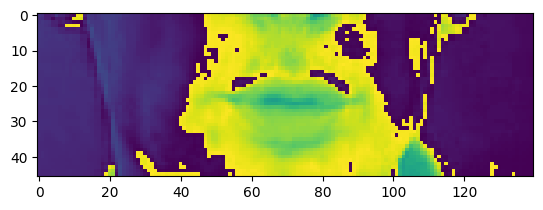

In [62]:
len(test)
frames, alignments = next(iter(data))
len(frames)
sample = data.as_numpy_iterator()
val = sample.next(); val[0]
# imageio.mimsave('./animation.gif', val[0][0], fps=10)
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [63]:
# Design Deep Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
yhat = model.predict(val[0])
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


<tf.Tensor: shape=(), dtype=string, numpy=b'zz!!!!!ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [67]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'zz!!!!!ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss'>

In [68]:
# Define the custom loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [90]:

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=CTCLoss)

In [83]:

# Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [84]:
# Define the model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [85]:
# Define the learning rate scheduler callback
schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [86]:
# Define the custom callback to produce examples
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [94]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)                    │ (None, 75, 46, 140, 128)    │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 75, 46, 140, 128)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 75, 23, 70, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_10 (Conv3D)                   │ (None, 75, 23, 70, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 75, 23, 70, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 75, 11, 35, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 75, 11, 35, 75)      │         518,475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 75, 11, 35, 75)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 75, 5, 17, 75)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 75, 6375)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 75, 256)             │       6,660,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 75, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 75, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 75, 41)              │          10,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,415,774 (96.95 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,943,850 (64.64 MB)

In [87]:
example_callback = ProduceExample(test)
example_callback

In [88]:
# Train the model
train = data.take(450)
test = data.skip(450)
callbacks=[checkpoint_callback, schedule_callback, example_callback]
callbacks


In [ ]:
model.train(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [2]:
#dataset for prediction
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=e3f31abd-85fe-429d-bb21-d5f4cccebe0c
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 169MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [102]:
model.load_weights('models/checkpoints.weights.h5')

In [103]:
test_data = test.as_numpy_iterator()

In [104]:
sample = test_data.next()

In [106]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


In [ ]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [118]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [119]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'!'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ze2u'>]

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]